[(0.5518794794867146, 0.8339238814912744), (0.4216961889770523, 0.9067371858494777), (0, 1.070111916936896), (0, 1.129668424892967)]


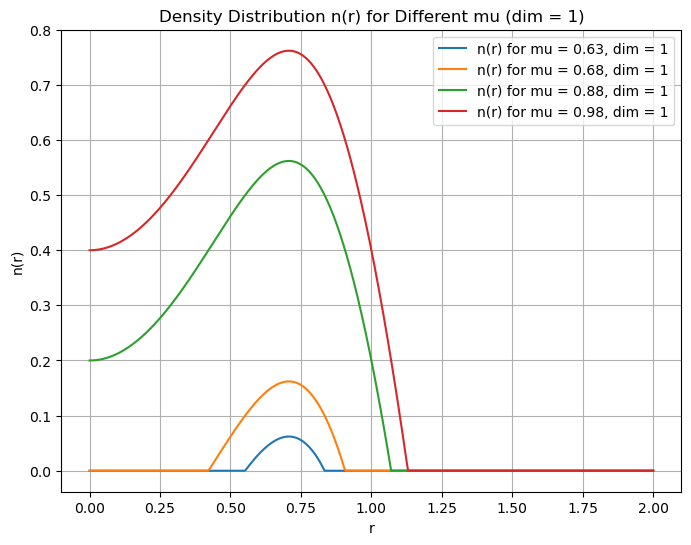

In [14]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constants
U0 = 1.0  # Scaling constant
hw = 1.0  # Constant involving hbar and frequency
s = 1.0  # Length scaling factor
delta = 0.5  # Trap parameter
omega = 0.3  # Trap parameter
r_max = 2  # Edge of the computation box
dim = 1  # Number of dimensions in the BEC, for metric factor in integration

# Metric factor dependent on dimension
def metric_factor(r, dim):
    if dim == 1:
        return 2
    elif dim == 2:
        return 2 * np.pi * r
    elif dim == 3:
        return 4 * np.pi * r**2
    else:
        return 0.0

# Potential function V(r)
def V(r, s, delta, omega):
    arg = ((r / s)**2 - delta)**2 + (2 * omega)**2
    return hw * np.sqrt(arg)


# Compute the potential at the center of the trap (r=0)
V0 = V(0, s, delta, omega)


# Compute the Thomas-Fermi radii
def tf_radii(mu, s, delta, omega, hw):
    nu = mu / hw
    if nu**2 <= (2 * omega)**2:
        return None, None  # No valid radii
    inner_root = np.sqrt(nu**2 - (2 * omega)**2)
    r_TF_minus = s * np.sqrt(delta - inner_root) if delta - inner_root >= 0 else 0
    r_TF_plus = s * np.sqrt(delta + inner_root) if delta + inner_root >= 0 else 0
    return r_TF_minus, r_TF_plus


# Radial density integrand
def n_r(r, mu, s, delta, omega, U0, dim):
    V_r = V(r, s, delta, omega)
    if mu > V_r:
        return (mu - V_r) / U0 * metric_factor(r, dim)
    else:
        return 0.0

# Updated Integral for total number of particles N(mu)
def N_mu(mu, s, delta, omega, U0, dim):
    r_min, r_max = tf_radii(mu, s, delta, omega, hw)
    if r_min is None or r_max is None:
        return 0.0  # No valid BEC region

    # Perform the integration over the valid range
    integral, _ = quad(n_r, r_min, r_max, args=(mu, s, delta, omega, U0, dim))
    return integral

# Generate data points for N(mu)
mu_values = np.linspace(0.1, 5.0, 100)
N_values = [N_mu(mu, s, delta, omega, U0, dim) for mu in mu_values]

# Filter out duplicate N values
unique_indices = np.unique(N_values, return_index=True)[1]
N_values_filtered = [N_values[i] for i in sorted(unique_indices)]
mu_values_filtered = [mu_values[i] for i in sorted(unique_indices)]

# Interpolate to find mu(N)
mu_of_N = interp1d(N_values_filtered, mu_values_filtered, kind="cubic", fill_value="extrapolate")

# Examples: Plot n(r) for multiple mu values
mu_examples = [V0 - 0.15, V0 - 0.1, V0 + 0.1, V0 + 0.2]  # Examples for mu
r_values = np.linspace(0, r_max, 500)

# Compute Thomas-Fermi radii for mu_examples
tf_examples = [tf_radii(mu, s, delta, omega, hw) for mu in mu_examples]
print(tf_examples)

# Initialize plot
plt.figure(figsize=(8, 6))
for mu in mu_examples:
    n_values = [n_r(r, mu, s, delta, omega, U0, dim) for r in r_values]
    plt.plot(r_values, n_values, label=f"n(r) for mu = {mu:.2f}, dim = {dim}")

# Plot settings
plt.xlabel("r")
plt.ylabel("n(r)")
plt.title(f"Density Distribution n(r) for Different mu (dim = {dim})")
plt.legend()
plt.grid()
plt.show()